In [4]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import VGG16  
from sklearn.utils import shuffle

In [5]:
train_dir ='C:\\Users\\Pratham Borgaonkar\\Desktop\\project\\dataset\\Training'
test_dir ='C:\\Users\\Pratham Borgaonkar\\Desktop\\project\\dataset\\Testing'

## Shuffle the dataset to avoid overfitting

In [6]:
# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [7]:
test_paths

['C:\\Users\\Pratham Borgaonkar\\Desktop\\project\\dataset\\Testing\\pituitary\\Te-pi_0205.jpg',
 'C:\\Users\\Pratham Borgaonkar\\Desktop\\project\\dataset\\Testing\\pituitary\\Te-pi_0279.jpg',
 'C:\\Users\\Pratham Borgaonkar\\Desktop\\project\\dataset\\Testing\\notumor\\Te-no_0029.jpg',
 'C:\\Users\\Pratham Borgaonkar\\Desktop\\project\\dataset\\Testing\\meningioma\\Te-me_0067.jpg',
 'C:\\Users\\Pratham Borgaonkar\\Desktop\\project\\dataset\\Testing\\notumor\\Te-no_0197.jpg',
 'C:\\Users\\Pratham Borgaonkar\\Desktop\\project\\dataset\\Testing\\glioma\\Te-gl_0134.jpg',
 'C:\\Users\\Pratham Borgaonkar\\Desktop\\project\\dataset\\Testing\\notumor\\Te-no_0248.jpg',
 'C:\\Users\\Pratham Borgaonkar\\Desktop\\project\\dataset\\Testing\\notumor\\Te-no_0344.jpg',
 'C:\\Users\\Pratham Borgaonkar\\Desktop\\project\\dataset\\Testing\\pituitary\\Te-pi_0088.jpg',
 'C:\\Users\\Pratham Borgaonkar\\Desktop\\project\\dataset\\Testing\\glioma\\Te-gl_0246.jpg',
 'C:\\Users\\Pratham Borgaonkar\\Desktop\\p

In [8]:
print(len(test_labels))
print(len(test_paths))
print(len(train_labels))
print(len(train_paths))

1311
1311
5712
5712


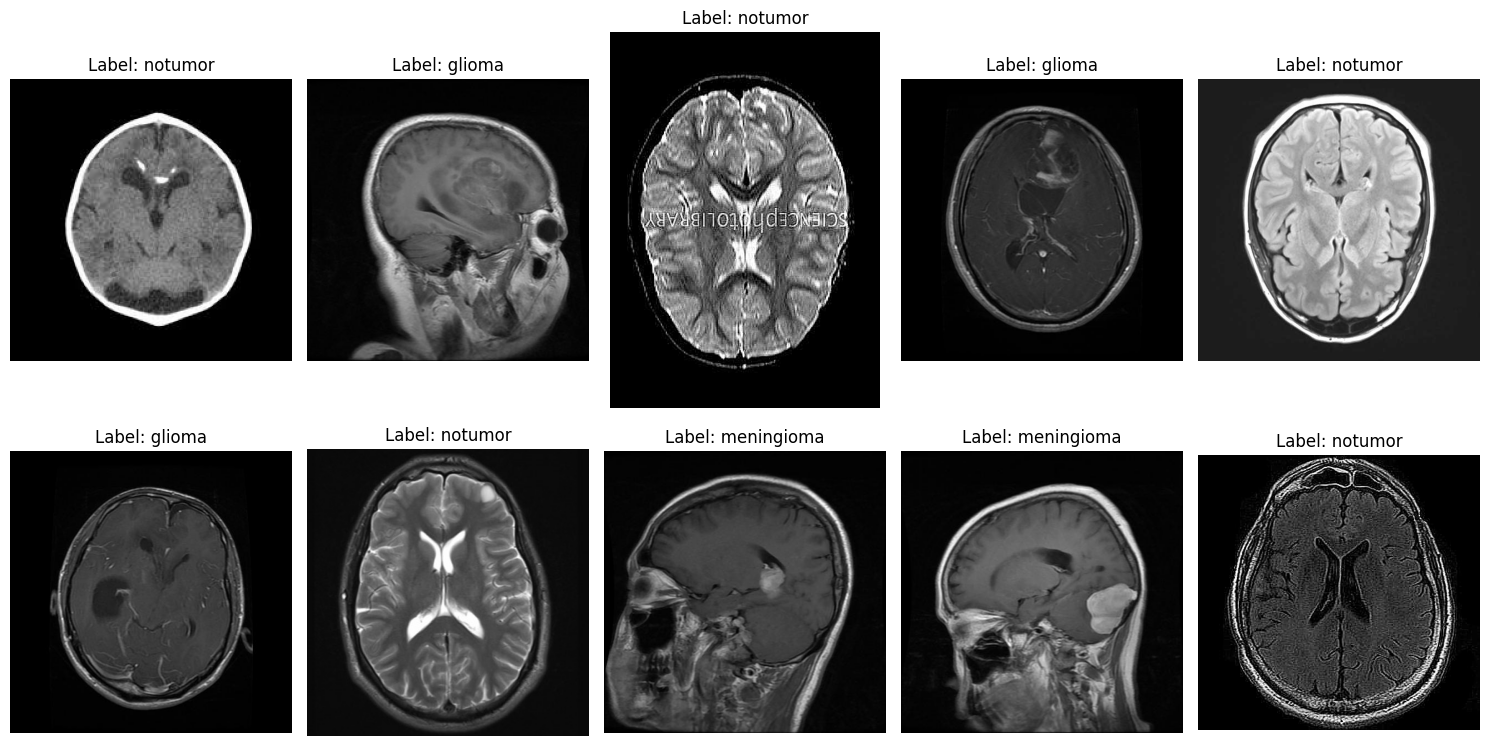

In [9]:
# 1. Select random indices
random_indices = random.sample(range(len(train_paths)), 10)

# 2. Create the figure
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

# 3. Loop through indices and plot
for i, idx in enumerate(random_indices):
    # Load image (OpenCV loads in BGR, so we convert to RGB)
    img = cv2.imread(train_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {train_labels[idx]}")
    axes[i].axis('off') # Hide axes for a cleaner look

plt.tight_layout()
plt.show()

In [10]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(image_size, image_size))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Multiply, Concatenate, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import os
from tensorflow.keras.layers import Add

def spatial_attention(input_feature):
    # 1. Average Pooling
    avg_pool = tf.reduce_mean(input_feature, axis=3, keepdims=True)
    # 2. Max Pooling
    max_pool = tf.reduce_max(input_feature, axis=3, keepdims=True)
    # 3. Combine
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    # 4. Attention Map
    attention_map = Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid', use_bias=False)(concat)
    
    # 5. Apply Attention (The Highlight)
    refined_feature = Multiply()([input_feature, attention_map])
    
    # === THE FIX: Add Original Features Back ===
    # This prevents the model from losing "Context" info needed for Class 3
    return Add()([input_feature, refined_feature])

# Model architecture

In [12]:
image_size=128
base_model=VGG16(input_shape=(image_size,image_size,3),include_top=False,weights='imagenet')

In [13]:
for i in base_model.layers:
    i.trainable =False

In [14]:
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [25]:
inputs = Input(shape=(image_size, image_size, 3))
# Pass it through VGG16
x = base_model(inputs, training=False)
# === ADD ATTENTION HERE ===
x = spatial_attention(x)
x = GlobalAveragePooling2D()(x)

In [26]:
# Continue with your exact layers
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)  # Slightly higher dropout because we have fewer parameters now
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(4, activation='softmax')(x) # Assuming 4 classes

model = Model(inputs=inputs, outputs=outputs)

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 4, 4, 512)    14714688    ['input_3[0][0]']                
                                                                                                  
 tf.math.reduce_mean_1 (TFOpLam  (None, 4, 4, 1)     0           ['vgg16[1][0]']                  
 bda)                                                                                             
                                                                                            

In [28]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [29]:
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 10

In [30]:
# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
285/285 [==============================] - 13s 40ms/step - loss: 0.1873 - sparse_categorical_accuracy: 0.9402
Epoch 2/10
285/285 [==============================] - 11s 40ms/step - loss: 0.0684 - sparse_categorical_accuracy: 0.9779
Epoch 3/10
285/285 [==============================] - 11s 40ms/step - loss: 0.0451 - sparse_categorical_accuracy: 0.9863
Epoch 4/10
285/285 [==============================] - 11s 40ms/step - loss: 0.0416 - sparse_categorical_accuracy: 0.9863
Epoch 5/10
285/285 [==============================] - 11s 40ms/step - loss: 0.0341 - sparse_categorical_accuracy: 0.9905
Epoch 6/10
285/285 [==============================] - 11s 39ms/step - loss: 0.0341 - sparse_categorical_accuracy: 0.9902
Epoch 7/10
285/285 [==============================] - 11s 39ms/step - loss: 0.0311 - sparse_categorical_accuracy: 0.9898
Epoch 8/10
285/285 [==============================] - 11s 39ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9916
Epoch 9/10
285/285 [============

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report with attention:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 [==============================] - 2s 53ms/step
Classification Report with attention:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       300
           1       0.97      0.94      0.96       306
           2       1.00      1.00      1.00       405
           3       0.97      1.00      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



Confusion Matrix:
[[290   9   0   1]
 [  7 289   1   9]
 [  2   0 403   0]
 [  0   1   0 299]]


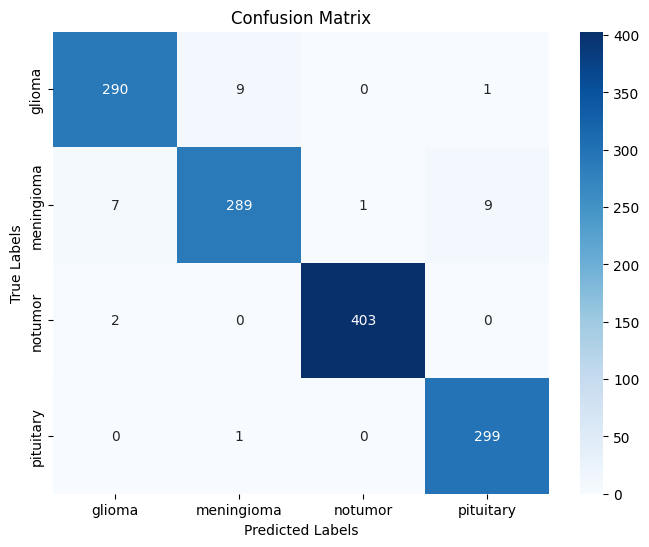

In [32]:

# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

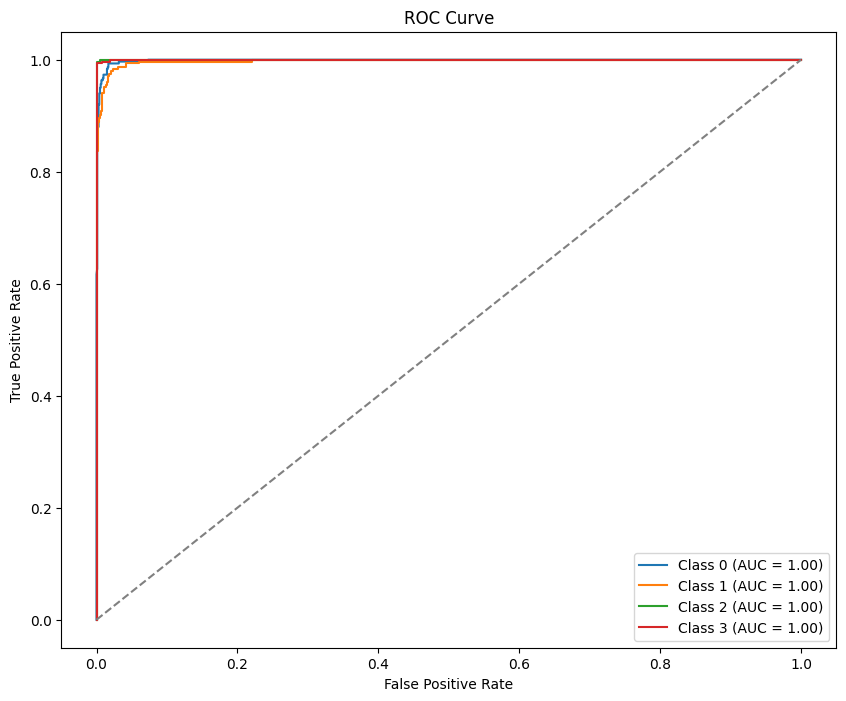

In [33]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [34]:
# Save the entire model
model.save('model_5.h5')

In [65]:
import cv2
import numpy as np
import tensorflow as tf
import os

def final_fix_predict_v4(img_path, model):
    if not os.path.exists(img_path):
        return None, None, "File Not Found", 0, None

    try:
        # 1. MAPPING & DIMENSIONS
        mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
        img_size = 128

        # 2. LOAD & NORMALIZE (1./255 scaling)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        
        # Scaling matching the 'augment_image' function in your notebook
        img_scaled = img_array / 255.0 
        img_expanded = np.expand_dims(img_scaled, axis=0)

        # 3. GET PREDICTION
        preds = model.predict(img_expanded, verbose=0)
        class_idx = np.argmax(preds[0])
        confidence = np.max(preds[0]) * 100
        label_name = mapping[class_idx]

        # 4. PREPARE FIGURES (RGB format)
        input_img = img_array.astype(np.uint8).copy()
        output_img = img_array.astype(np.uint8).copy() # Fresh copy for drawing
        heatmap_255 = np.zeros((img_size, img_size), dtype=np.uint8)

        # 5. LOCALIZATION
        if class_idx != 2: 
            vgg_base = model.get_layer('vgg16')
            last_conv = vgg_base.get_layer("block5_conv3")
            grad_model = tf.keras.models.Model([vgg_base.input], [last_conv.output, vgg_base.output])
            
            img_tensor = tf.Variable(tf.cast(img_expanded, tf.float32)) #
            with tf.GradientTape() as tape:
                tape.watch(img_tensor)
                conv_out, vgg_preds = grad_model(img_tensor)
                loss = vgg_preds[:, class_idx]
            
            grads = tape.gradient(loss, conv_out)[0] #
            weights = tf.reduce_mean(grads, axis=(0, 1))
            cam = conv_out[0] @ weights[..., tf.newaxis]
            cam = tf.squeeze(tf.maximum(cam, 0) / (tf.math.reduce_max(cam) + 1e-10)).numpy()
            
            # Boundary Trace
            heatmap_255 = np.uint8(255 * cv2.resize(cam, (img_size, img_size)))
            _, thresh = cv2.threshold(heatmap_255, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) #
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if contours:
                best_cnt = max(contours, key=cv2.contourArea)
                #  COLOR FIX 
                # RGB RED: (255, 0, 0)
                # THICKNESS: 1 (Small width)
                cv2.drawContours(output_img, [best_cnt], -1, (255, 0, 0), 2)

        return input_img, output_img, label_name, confidence, heatmap_255

    except Exception as e:
        print(f"Error: {e}")
        return None, None, "ERROR", 0, None

In [63]:
import cv2
import numpy as np
import tensorflow as tf
import os

def final_fix_predict_v4(img_path, model):
    if not os.path.exists(img_path):
        return None, None, "File Not Found", 0, None

    try:
        # 1. MAPPING & DIMENSIONS
        mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
        img_size = 128

        # 2. LOAD & NORMALIZE (1./255 scaling)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        
        # Scaling matching the 'augment_image' function in your notebook
        img_scaled = img_array / 255.0 
        img_expanded = np.expand_dims(img_scaled, axis=0)

        # 3. GET PREDICTION
        preds = model.predict(img_expanded, verbose=0)
        class_idx = np.argmax(preds[0])
        confidence = np.max(preds[0]) * 100
        label_name = mapping[class_idx]

        # 4. PREPARE FIGURES (RGB format)
        input_img = img_array.astype(np.uint8).copy()
        output_img = img_array.astype(np.uint8).copy() # Fresh copy for drawing
        heatmap_255 = np.zeros((img_size, img_size), dtype=np.uint8)

        # 5. LOCALIZATION
        if class_idx != 2: 
            vgg_base = model.get_layer('vgg16')
            last_conv = vgg_base.get_layer("block5_conv3")
            grad_model = tf.keras.models.Model([vgg_base.input], [last_conv.output, vgg_base.output])
            
            img_tensor = tf.Variable(tf.cast(img_expanded, tf.float32)) 
            with tf.GradientTape() as tape:
                tape.watch(img_tensor)
                conv_out, vgg_preds = grad_model(img_tensor)
                loss = vgg_preds[:, class_idx]
            
            grads = tape.gradient(loss, conv_out)[0] 
            weights = tf.reduce_mean(grads, axis=(0, 1))
            cam = conv_out[0] @ weights[..., tf.newaxis]
            cam = tf.squeeze(tf.maximum(cam, 0) / (tf.math.reduce_max(cam) + 1e-10)).numpy()
            
            # --- UPDATED BOUNDARY TRACE LOGIC ---
            heatmap_255 = np.uint8(255 * cv2.resize(cam, (img_size, img_size)))
            
            # CHANGE HERE: Replaced Otsu with a fixed high threshold (190)
            # 50-100 captures Blue/Green
            # 190+ captures Red/Yellow (The core)
            _, thresh = cv2.threshold(heatmap_255, 190, 255, cv2.THRESH_BINARY) 
            
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if contours:
                best_cnt = max(contours, key=cv2.contourArea)
                # Drawing Red Contour with thickness 2
                cv2.drawContours(output_img, [best_cnt], -1, (255, 0, 0), 1)

        return input_img, output_img, label_name, confidence, heatmap_255

    except Exception as e:
        print(f"Error: {e}")
        return None, None, "ERROR", 0, None

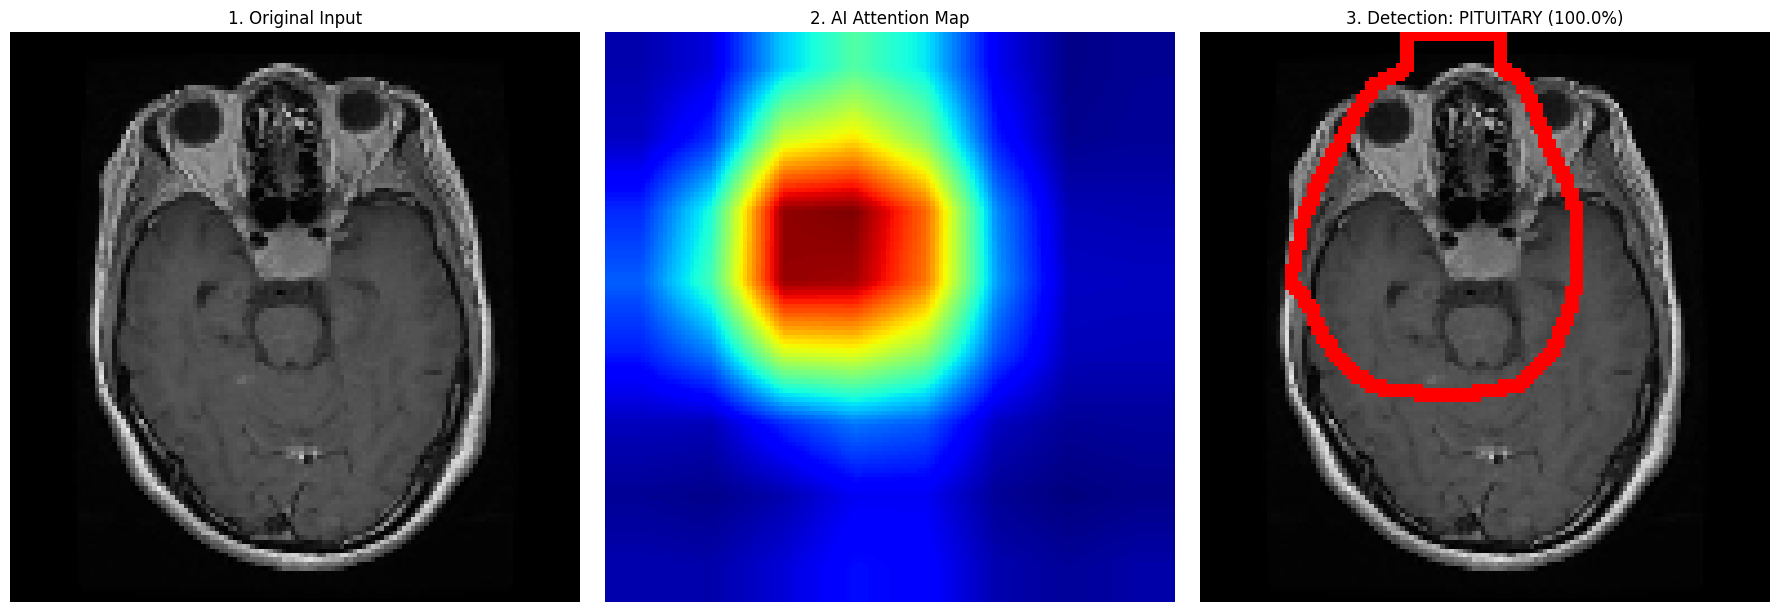

In [66]:
import matplotlib.pyplot as plt

# 1. Path
test_path = r'C:\Users\Pratham Borgaonkar\Desktop\project\dataset\Testing\pituitary\Te-pi_0016.jpg'

# 2. Run the V4 function
in_img, out_img, label, conf, hmap = final_fix_predict_v4(test_path, model)

if in_img is not None:
    plt.figure(figsize=(18, 6))

    # Figure 1: Original Input (Clean)
    plt.subplot(1, 3, 1)
    plt.imshow(in_img)
    plt.title("1. Original Input")
    plt.axis('off')

    # Figure 2: Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(hmap, cmap='jet')
    plt.title("2. AI Attention Map")
    plt.axis('off')

    # Figure 3: Output with THIN RED Boundary
    plt.subplot(1, 3, 3)
    plt.imshow(out_img) 
    plt.title(f"3. Detection: {label.upper()} ({conf:.1f}%)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()